## NRL set 1 using deep learning.
### Tensorflow version
### Edgar Acuna
### Abril 2020

In [1]:
import keras
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
df1=pd.read_csv("c://onr2020/NRLset1_part1.csv",header=None)
df2=pd.read_csv("c://onr2020/NRLset1_part2.csv",header=None)
df3=pd.read_csv("c://onr2020/NRLset1_part3.csv",header=None)
df4=pd.read_csv("c://onr2020/NRLset1_part4.csv",header=None)
df5=pd.read_csv("c://onr2020/NRLset1_part5.csv",header=None)
df6=pd.read_csv("c://onr2020/NRLset1_part6.csv",header=None)
df7=pd.read_csv("c://onr2020/NRLset1_part7.csv",header=None)
df8=pd.read_csv("c://onr2020/NRLset1_part8.csv",header=None)
y=pd.read_csv("c://onr2020/labels.csv",header=None)

In [3]:
dfset1=pd.concat([df1,df2,df3,df4,df5,df6,df7,df8],ignore_index=True)
lb = LabelBinarizer()
y= lb.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(dfset1,y, test_size=0.3,random_state=0)
print('Train dimension:');print(X_train.shape)
print('Test dimension:');print(X_test.shape)
#print(y_train[arr[index:index+batch_size]])

Train dimension:
(12600, 1701)
Test dimension:
(5400, 1701)


In [4]:
lb = LabelBinarizer()
y= lb.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(dfset1,y, test_size=0.3,random_state=0)
print('Train dimension:');print(X_train.shape)
print('Test dimension:');print(X_test.shape)
## Changing labels to one-hot encoded vector
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)
print('Train labels dimension:');print(y_train.shape)
print('Test labels dimension:');print(y_test.shape)

Train dimension:
(12600, 1701)
Test dimension:
(5400, 1701)
Train labels dimension:
(12600, 40)
Test labels dimension:
(5400, 40)


In [5]:
## Importing required libraries
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score, accuracy_score
s = tf.InteractiveSession()

In [6]:
## Defining various initialization parameters for 784(Input)-512-256-10(Output) MLP model
num_classes = y_train.shape[1]
num_features = X_train.shape[1]
num_output = y_train.shape[1]
num_layers_0 = 512
num_layers_1 = 256
starter_learning_rate = 0.001
regularizer_rate = 0.1

In [7]:
print(num_classes,num_features, X_train.shape[0])

40 1701 12600


In [8]:
# Placeholders for the input data
input_X = tf.placeholder('float32',shape =(None,num_features),name="input_X")
input_y = tf.placeholder('float32',shape = (None,num_classes),name='input_Y')
## for dropout layer
keep_prob = tf.placeholder(tf.float32)

In [9]:
## Weights initialized by random normal function with std_dev = 1/sqrt(number of input features)
weights_0 = tf.Variable(tf.random_normal([num_features,num_layers_0], stddev=(1/tf.sqrt(float(num_features)))))
bias_0 = tf.Variable(tf.random_normal([num_layers_0]))
weights_1 = tf.Variable(tf.random_normal([num_layers_0,num_layers_1], stddev=(1/tf.sqrt(float(num_layers_0)))))
bias_1 = tf.Variable(tf.random_normal([num_layers_1]))
weights_2 = tf.Variable(tf.random_normal([num_layers_1,num_output], stddev=(1/tf.sqrt(float(num_layers_1)))))
bias_2 = tf.Variable(tf.random_normal([num_output]))

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
## Initializing weigths and biases
hidden_output_0 = tf.nn.relu(tf.matmul(input_X,weights_0)+bias_0)
hidden_output_0_0 = tf.nn.dropout(hidden_output_0, keep_prob)
hidden_output_1 = tf.nn.relu(tf.matmul(hidden_output_0_0,weights_1)+bias_1)
hidden_output_1_1 = tf.nn.dropout(hidden_output_1, keep_prob)
predicted_y = tf.sigmoid(tf.matmul(hidden_output_1_1,weights_2) + bias_2)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [11]:
## Defining the loss function
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=predicted_y,labels=input_y)) \
        + regularizer_rate*(tf.reduce_sum(tf.square(bias_0)) + tf.reduce_sum(tf.square(bias_1)))

In [12]:
# Variable learning rate
learning_rate = tf.train.exponential_decay(starter_learning_rate, 0, 5, 0.85, staircase=True)
## Adam optimzer for finding the right weight
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss,var_list=[weights_0,weights_1,weights_2,
                                                                         bias_0,bias_1,bias_2])

In [13]:
## Metrics definition
correct_prediction = tf.equal(tf.argmax(y_train,1), tf.argmax(predicted_y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [14]:
## Training parameters
batch_size = 400
epochs=150
dropout_prob = 0.5
training_accuracy = []
training_loss = []
testing_accuracy = []
s.run(tf.global_variables_initializer())
for epoch in range(epochs):    
    arr = np.arange(X_train.shape[0])
    np.random.shuffle(arr)
    for index in range(0,X_train.shape[0],batch_size):
        s.run(optimizer, {input_X: X_train.iloc[arr[index:index+batch_size]],
                          input_y: y_train[arr[index:index+batch_size]],
                        keep_prob:dropout_prob})
    training_accuracy.append(s.run(accuracy, feed_dict= {input_X:X_train, 
                                                         input_y: y_train,keep_prob:1}))
    training_loss.append(s.run(loss, {input_X: X_train, 
                                      input_y: y_train,keep_prob:1}))
    
    ## Evaluation of model
    testing_accuracy.append(accuracy_score(y_test.argmax(1), 
                            s.run(predicted_y, {input_X: X_test,keep_prob:1}).argmax(1)))
    print("Epoch:{0}, Train loss: {1:.2f} Train acc: {2:.3f}, Test acc:{3:.3f}".format(epoch,
                                                                    training_loss[epoch],
                                                                    training_accuracy[epoch],
                                                                   testing_accuracy[epoch]))


Epoch:0, Train loss: 75.03 Train acc: 0.027, Test acc:0.021
Epoch:1, Train loss: 71.39 Train acc: 0.027, Test acc:0.026
Epoch:2, Train loss: 67.94 Train acc: 0.029, Test acc:0.028
Epoch:3, Train loss: 64.69 Train acc: 0.032, Test acc:0.030
Epoch:4, Train loss: 61.61 Train acc: 0.034, Test acc:0.027
Epoch:5, Train loss: 58.69 Train acc: 0.039, Test acc:0.032
Epoch:6, Train loss: 55.92 Train acc: 0.035, Test acc:0.032
Epoch:7, Train loss: 53.29 Train acc: 0.048, Test acc:0.044
Epoch:8, Train loss: 50.79 Train acc: 0.051, Test acc:0.045
Epoch:9, Train loss: 48.42 Train acc: 0.046, Test acc:0.042
Epoch:10, Train loss: 46.16 Train acc: 0.059, Test acc:0.051
Epoch:11, Train loss: 44.00 Train acc: 0.067, Test acc:0.060
Epoch:12, Train loss: 41.96 Train acc: 0.069, Test acc:0.065
Epoch:13, Train loss: 40.00 Train acc: 0.096, Test acc:0.086
Epoch:14, Train loss: 38.15 Train acc: 0.104, Test acc:0.096
Epoch:15, Train loss: 36.43 Train acc: 0.083, Test acc:0.074
Epoch:16, Train loss: 34.72 Train 

Epoch:136, Train loss: 3.02 Train acc: 0.550, Test acc:0.549
Epoch:137, Train loss: 3.04 Train acc: 0.505, Test acc:0.501
Epoch:138, Train loss: 3.02 Train acc: 0.511, Test acc:0.491
Epoch:139, Train loss: 3.03 Train acc: 0.514, Test acc:0.509
Epoch:140, Train loss: 3.03 Train acc: 0.508, Test acc:0.497
Epoch:141, Train loss: 3.02 Train acc: 0.520, Test acc:0.504
Epoch:142, Train loss: 3.01 Train acc: 0.572, Test acc:0.561
Epoch:143, Train loss: 3.01 Train acc: 0.530, Test acc:0.517
Epoch:144, Train loss: 3.01 Train acc: 0.538, Test acc:0.522
Epoch:145, Train loss: 2.99 Train acc: 0.550, Test acc:0.535
Epoch:146, Train loss: 3.02 Train acc: 0.546, Test acc:0.538
Epoch:147, Train loss: 3.03 Train acc: 0.531, Test acc:0.524
Epoch:148, Train loss: 3.02 Train acc: 0.527, Test acc:0.511
Epoch:149, Train loss: 3.00 Train acc: 0.536, Test acc:0.525


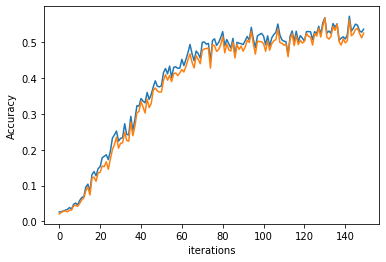

Train Accuracy: 0.54
Test Accuracy:0.52


In [16]:
## Plotting chart of training and testing accuracy as a function of iterations
iterations = list(range(epochs))
plt.plot(iterations, training_accuracy, label='Train')
plt.plot(iterations, testing_accuracy, label='Test')
plt.ylabel('Accuracy')
plt.xlabel('iterations')
plt.show()
print("Train Accuracy: {0:.2f}".format(training_accuracy[-1]))
print("Test Accuracy:{0:.2f}".format(testing_accuracy[-1]))